<a href="https://colab.research.google.com/github/kangmg/PySCF4ASE/blob/main/test_notebooks/benzene_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <p><font size=5 color="#80aaff">Write requirements.txt</font></p>
#@markdown Write an appropriate requirements.txt for your CUDA version.
%%bash

# requirements.txt
echo 'ase' > requirements.txt
echo 'pyscf' >> requirements.txt
echo 'torch' >> requirements.txt

# check CUDA VERSION
NVCC_VERSION=$(nvcc --version | grep -oP 'release \K[0-9]+\.[0-9]+' | cut -d'.' -f1)

echo -e "\033[1;34mYour CUDA Version :\033[0m $NVCC_VERSION"

# add the appropriate gpu4pysf & cutensor packages for your CUDA version
# refer : https://github.com/pyscf/gpu4pyscf/blob/master/README.md
if [ "$NVCC_VERSION" -eq 11 ]; then
  echo "gpu4pyscf-cuda11x" >> requirements.txt
  echo "cutensor-cu11" >> requirements.txt
elif [ "$NVCC_VERSION" -eq 12 ]; then
  echo "gpu4pyscf-cuda12x" >> requirements.txt
  echo "cutensor-cu12" >> requirements.txt
else
  echo -e "\033[1;31mWARNING\033[0m gpu4pyscf not supported your CUDA Version"
fi

echo ''
echo -e '\033[1;32mrequirements.txt\033[0m'
echo -e '\033[1;32m----------------\033[0m'
cat requirements.txt
echo -e '\033[1;32m----------------\033[0m'

Your CUDA Version : 12

requirements.txt
----------------
ase
pyscf
torch
gpu4pyscf-cuda12x
cutensor-cu12
----------------


In [2]:
#@title <p><font size=5 color="#80aaff">Setup</font></p>

# install packages
%pip install -q -r requirements.txt

# colab gpu error
import locale
locale.getpreferredencoding = lambda: "UTF-8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.0/385.0 kB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 MB 2.9 MB/s eta 0:00:00


In [3]:
#@title <p><font size=5 color="#80aaff">PySCF Calculator for ASE interface</font></p>


'''

===================================================
DFT-D4 DFT supported functionals
---------------------------------------------------

Use D4 if the specified functional is avialable.
Currently, only a subset of functionals in DFT-D4
is supported. It includes :

B3LYP, B97, B1LYP, PBE0, PW6B95, M06L, M06, WB97,
WB97X, CAMB3LYP, PBE02, PBE0DH, MPW1K, MPWB1K,
B1B95, B1PW91, B2GPPLYP, B2PLYP, B3P86, B3PW91,
O3LYP, REVPBE, REVPBE0, REVTPSS, REVTPSSH, SCAN,
TPSS0, TPSSH, X3LYP, TPSS, BP86, BLYP, BPBE,
MPW1PW91, MPW1LYP, PBE, RPBE, and PW91.


Ref. https://manual.q-chem.com/6.0/subsec_DFT-D.html

===================================================



[Units]
=======  ===========  =============
Program  Quantities   Unit
-------  -----------  -------------
PySCF    Energy       Ha
PySCF    Force        Ha/Bohr
ASE      Energy       eV
ASE      Force        eV/Ang
=======  ===========  =============



===================================================
pyscf xc, disp, nlc 사용 관련 참고
---------------------------------------------------

xc에 disp correction(e.g. d3bj d4 등을 붙여주면 disp correciton이 자동으로 수행됨)
nlc랑 disp랑 둘 다 계산되는 걸 주의해야 함


https://github.com/pyscf/pyscf/blob/master/examples/dft/16-dft_d3.py

===================================================
'''

import numpy as np
from ase.calculators.calculator import Calculator, all_changes
from ase.units import Ha, Bohr
import torch
import pyscf

class PySCFCalculator(Calculator):
    '''
    Description
    ===========
    PySCF ASE Calculator for dft caculations
    '''

    '''
    ===============
    Units
    ---------------
    Energy  eV
    Force   eV/Ang
    ===============
    '''


    implemented_properties = ['energy', 'forces']

    default_parameters = {
        'charge': 0, # system charge
        'spin': 0, # (= nelec alpha-beta = 2S)
        'symmetry': False, # point group symmetry : e.g. Cs or C2v Ref. https://github.com/pyscf/pyscf/blob/master/examples/gto/13-symmetry.py
        'basis': 'def2-tzvp', # basis set
        'xc': 'wb97m-d3bj', # xc functional
        'density_fit': True, # resolution of identity approximation
        'auxbasis': 'auto', # basis for density_fit : e.g. 'cc-pvdz-jkfit' or 'auto'(pyscf sets automatically)
        'device': 'auto', # gpu, cpu
        'disp': None, # dispersion correction : d3bj d4 d3 etc.
        'nlc': 'auto', # non-local correlation. :  0, 'auto', nlc-functional
        # [Note]
        # Set nlc to 0 when D3 and D4 dispersion corrections are applied
        # https://github.com/pyscf/pyscf/blob/master/examples/dft/15-nlc_functionals.py
        # https://github.com/pyscf/pyscf/blob/master/examples/dft/16-dft_d3.py
        'max_cycle': 50, # max number of iterations
        'conv_tol': 1e-9, # converge threshold
        'verbose' : 4, # output log level
        'max_memory': 150000, # MB unit
        'chkfile': None, # chkpoint file contains MOs, orbital energies etc. : (str) e.g. './checkpoint/pyscf.chk'
        'output': None, # log file : (str) e.g. './output/pyscf_output.log'
        # TODO : conv_tol_grad, init_guess
    }

    def _set_device(self):
        # set device
        if self.parameters.device == 'auto':
            self.parameters.device = 'gpu' if torch.cuda.is_available() else 'cpu'
        # import modules : dft
        if self.parameters.device == 'cpu':
            from pyscf import dft
            self.dft = dft
        elif self.parameters.device == 'gpu':
            from gpu4pyscf import dft
            self.dft = dft
        else:
            raise ValueError(f"Invalid device: {self.parameters.device}, 'gpu' or 'cpu' supported.")

    def __init__(self, restart=None, label='PySCF', **kwargs):
        super().__init__(restart=restart, label=label, **kwargs)
        self.mol = None
        self.mf = None


    def calculate(self, atoms=None, properties=['energy'], system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)

        self._set_device()

        if self.atoms is None:
            raise ValueError("atoms object is not set.")

        if system_changes:
            self.results.clear()
            self.mol = None
            self.mf = None

        if self.mol is None:
            self._generate_molecule()

        if self.mf is None:
            self._run_dft()

        if 'energy' in properties and 'energy' not in self.results:
            # pyscf energy unit : Hatree
            # ase energy unit : eV
            self.results['energy'] = self.mf.e_tot * Ha

        if 'forces' in properties and 'forces' not in self.results:
            # pyscf force unit : Ha/Bohr
            # ase force unit : eV/Ang
            self.results['forces'] = self._calculate_forces() * Ha / Bohr

    def _generate_molecule(self):
        positions = self.atoms.get_positions()
        symbols = self.atoms.get_chemical_symbols()
        atom_str = "; ".join([f"{s} {p[0]} {p[1]} {p[2]}" for s, p in zip(symbols, positions)])
        self.mol = pyscf.M(atom=atom_str,
                         basis=self.parameters.basis,
                         charge=self.parameters.charge,
                         spin=self.parameters.spin,
                         symmetry=self.parameters.symmetry,
                         verbose = self.parameters.verbose,
                         max_memory=self.parameters.max_memory,
                         output=self.parameters.output,
                         unit='Angstrom')


    def _run_dft(self):
        self.mf = self.dft.RKS(self.mol)
        self.mf.xc = self.parameters.xc
        self.mf.max_cycle = self.parameters.max_cycle
        self.mf.conv_tol = self.parameters.conv_tol
        self.mf.disp = self.parameters.disp

        # checkpoint file : default is /tmp
        if self.parameters.chkfile:
            self.mf.chkfile = self.parameters.chkfile

        # non-local correlation
        if self.parameters.nlc != 'auto':
            self.mf.nlc = self.parameters.nlc

        # density_fit ( or resolution of identity (RI) approximation)
        if self.parameters.density_fit:
            if self.parameters.auxbasis == 'auto':
                self.mf.density_fit()
            elif self.parameters.auxbasis != 'auto':
                self.mf.density_fit(auxbasis=self.parameters.auxbasis)

        self.mf.kernel()

    def _calculate_forces(self):
        return -self.mf.nuc_grad_method().kernel() # unit : Ha/Bohr

In [4]:
%%writefile benzene.xyz
12

H      1.2194     -0.1652      2.1600
C      0.6825     -0.0924      1.2087
C     -0.7075     -0.0352      1.1973
H     -1.2644     -0.0630      2.1393
C     -1.3898      0.0572     -0.0114
H     -2.4836      0.1021     -0.0204
C     -0.6824      0.0925     -1.2088
H     -1.2194      0.1652     -2.1599
C      0.7075      0.0352     -1.1973
H      1.2641      0.0628     -2.1395
C      1.3899     -0.0572      0.0114
H      2.4836     -0.1022      0.0205

Writing benzene.xyz


In [14]:
from ase.io import read
from ase.optimize import BFGS

mol4gpu = read('benzene.xyz', format='xyz')
mol4cpu = read('benzene.xyz', format='xyz')

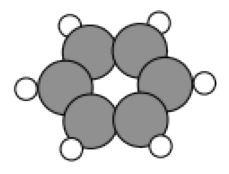

In [15]:
#@title check molecule

from ase.io import write
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# save image
write("mol.png", read('benzene.xyz', format='xyz'), rotation="-130x,0y,0z")
img = mpimg.imread("mol.png")

# plot image
plt.figure(figsize=(4, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

<p><font size=5 color="#80aaff">Benzene 구조 최적화 벤치마크</font></p>


> CPU 계산

In [18]:
%%time

gpu_calc = PySCFCalculator()

gpu_calc.parameters.device = 'gpu'
gpu_calc.parameters.verbose = 1

display(gpu_calc.parameters)

mol4gpu.calc = gpu_calc

gpu_opt = BFGS(mol4gpu)
gpu_opt.run(fmax=0.01)

{'charge': 0,
 'spin': 0,
 'symmetry': False,
 'basis': 'def2-tzvp',
 'xc': 'wb97m-d3bj',
 'density_fit': True,
 'auxbasis': 'auto',
 'device': 'gpu',
 'disp': None,
 'nlc': 'auto',
 'max_cycle': 50,
 'conv_tol': 1e-09,
 'verbose': 1,
 'max_memory': 150000,
 'chkfile': None,
 'output': None}

/usr/local/lib/python3.10/dist-packages/gpu4pyscf/lib/cutensor.py:138: UserWarning: using cupy as the tensor contraction engine.
  warnings.warn(f'using {contract_engine} as the tensor contraction engine.')
/usr/local/lib/python3.10/dist-packages/pyscf/gto/mole.py:1284: UserWarning: Function mol.dumps drops attribute _ctx_lock because it is not JSON-serializable
  warnings.warn(msg)


      Step     Time          Energy          fmax
BFGS:    0 15:15:39    -6324.002977        0.454796
BFGS:    1 15:16:44    -6324.014062        0.257673
BFGS:    2 15:17:49    -6324.019023        0.155465
BFGS:    3 15:18:54    -6324.023062        0.007939
CPU times: user 4min 39s, sys: 3.73 s, total: 4min 43s
Wall time: 4min 50s


True

> GPU 계산

In [19]:
%%time

cpu_calc = PySCFCalculator()

cpu_calc.parameters.device = 'cpu'
cpu_calc.parameters.verbose = 1

display(cpu_calc.parameters)

mol4cpu.calc = cpu_calc

cpu_opt = BFGS(mol4cpu)
cpu_opt.run(fmax=0.01)

{'charge': 0,
 'spin': 0,
 'symmetry': False,
 'basis': 'def2-tzvp',
 'xc': 'wb97m-d3bj',
 'density_fit': True,
 'auxbasis': 'auto',
 'device': 'cpu',
 'disp': None,
 'nlc': 'auto',
 'max_cycle': 50,
 'conv_tol': 1e-09,
 'verbose': 1,
 'max_memory': 150000,
 'chkfile': None,
 'output': None}

      Step     Time          Energy          fmax
BFGS:    0 15:42:43    -6324.002977        0.454894
BFGS:    1 15:52:08    -6324.014061        0.257660
BFGS:    2 16:01:31    -6324.019023        0.155463
BFGS:    3 16:10:53    -6324.023062        0.007945
CPU times: user 37min 9s, sys: 35.1 s, total: 37min 44s
Wall time: 37min 38s


True